<a href="https://colab.research.google.com/github/Joma986/Fuzzy-Project/blob/main/Hands_on_02_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-fuzzy
!pip install geneticalgorithm2
!pip install swig
!pip install gymnasium
!pip install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.7 MB/s eta 0:00:00


In [2]:
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

True Tesla T4


In [3]:
import gymnasium as gym
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
import math
from geneticalgorithm2 import geneticalgorithm2 as ga
import numpy as np
import torch
import gymnasium as gym
from concurrent.futures import ThreadPoolExecutor
from geneticalgorithm2 import geneticalgorithm2 as ga

# Mountain Car

Vamos agora rodar o SIF em um problema um pouquinho mais interessante, chamado Mountain Car.

In [4]:
# Define the fuzzy controller

def create_car_controller():
    x_pos = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'x_pos')
    velocity = ctrl.Antecedent(np.arange(-8, 8.01, 0.01), 'velocity')
    aceleration = ctrl.Consequent(np.arange(-1, 1.01, 0.01), 'aceleration')

    # Define membership functions for the input variables (position, velocity, angle, angular_velocity)
    x_pos['negative'] = fuzz.trapmf(x_pos.universe, [-1.1, -1, -0.05, 0])
    x_pos['zero'] = fuzz.trimf(x_pos.universe, [-0.05, 0, 0.05])
    x_pos['positive'] = fuzz.trapmf(x_pos.universe, [0, 0.05, 1, 1.1])

    velocity['negative'] = fuzz.trapmf(velocity.universe, [-8.1, -8.0, -1, 0])
    velocity['zero'] = fuzz.trimf(velocity.universe, [-1, 0, 1])
    velocity['positive'] = fuzz.trapmf(velocity.universe, [0, 1, 8, 8.1])

    aceleration['negative'] = fuzz.trapmf(aceleration.universe, [-1.0, -1.0, -0.8, -0.5])
    aceleration['little negative'] = fuzz.trimf(aceleration.universe, [-0.8, -0.5, 0])
    aceleration['zero'] = fuzz.trimf(aceleration.universe, [-0.5, 0, 0.5])
    aceleration['little positive'] = fuzz.trimf(aceleration.universe, [0, 0.5, 0.8])
    aceleration['positive'] = fuzz.trapmf(aceleration.universe, [0.5, 0.8, 1.0, 1.0])


    rules = [ctrl.Rule(antecedent=(x_pos['zero'] & velocity['positive']), consequent=(aceleration['positive'])),
             ctrl.Rule(antecedent=(x_pos['zero'] & velocity['negative']), consequent=(aceleration['negative'])),
             ctrl.Rule(antecedent=(x_pos['negative'] & velocity['positive']), consequent=(aceleration['positive'])),
             ctrl.Rule(antecedent=(x_pos['negative'] & velocity['zero']), consequent=(aceleration['little negative'])),
             ctrl.Rule(antecedent=(x_pos['negative'] & velocity['negative']), consequent=(aceleration['negative'])),
             ctrl.Rule(antecedent=(x_pos['positive'] & velocity['positive']), consequent=(aceleration['positive'])),
             ctrl.Rule(antecedent=(x_pos['positive'] & velocity['zero']), consequent=(aceleration['little positive'])),
             ctrl.Rule(antecedent=(x_pos['positive'] & velocity['negative']), consequent=(aceleration['negative'])),
            ]

    # Create the fuzzy control system for torque
    torque_ctrl = ctrl.ControlSystem(rules)

    # Create a simulation with the control system for torque
    torque_sim = ctrl.ControlSystemSimulation(torque_ctrl)

    return torque_sim


In [5]:
fuzzy_controller = create_car_controller()

import time

env = gym.make('MountainCarContinuous-v0', render_mode='human')

state = env.reset()
obs = state[0]
total_reward = 0
done = False
episode = 1
k = 0
x_poses = []
y_poses = []
a_speeds = []
actions = []
while not done:
    # theta_value = get_theta(obs[0], obs[1])
    x_poses.append(obs[0])
    y_poses.append(obs[1])
    try:
        fuzzy_controller.input['x_pos'] = obs[0] + 0.5
        fuzzy_controller.input['velocity'] = obs[1]*100
        fuzzy_controller.compute()
        action = fuzzy_controller.output['aceleration']
    except:
        action = 0
    # action = 0
    actions.append(action)
    obs, reward, done, _, _ = env.step([action])
    total_reward += reward
    k += 1

    time.sleep(0.1)

    if k > 300:
        break

print(total_reward)
env.close()

95.41974957649376


# Pendulum

Podemos também trabalhar em um problema um pouquinho mais complexo...

In [6]:
env = gym.make('Pendulum-v1', g=9.81) #, render_mode="human")

In [7]:
# Define the fuzzy controller

def create_controller(x):
    theta = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'theta')
    theta = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'theta')

    angular_velocity = ctrl.Antecedent(np.arange(-8, 8.01, 0.01), 'angular_velocity')
    torque = ctrl.Consequent(np.arange(-2, 2.01, 0.01), 'torque')

    x = np.asarray(x)
    for i in range(0, len(x) - 3, 4):
        x[i:i+4] = np.sort(x[i:i+4])

    # Define membership functions for the input variables (position, velocity, angle, angular_velocity)
    theta['negative'] = fuzz.trapmf(theta.universe, [-1.1, -1, -1 + x[0], 0])
    theta['zero'] = fuzz.trimf(theta.universe, [-1 + x[0], 0, 1 - x[1]])
    theta['positive'] = fuzz.trapmf(theta.universe, [0, 1 - x[1], 1, 1.1])

    angular_velocity['negative'] = fuzz.trapmf(angular_velocity.universe, [-8.1, -8.0, -8 + x[2], 0])
    angular_velocity['zero'] = fuzz.trimf(angular_velocity.universe, [-8 + x[2], 0, 8 - x[3]])
    angular_velocity['positive'] = fuzz.trapmf(angular_velocity.universe, [0, 8 - x[3], 8, 8.1])

    # Define membership functions for the output variables (throttle and orientation)
    torque['negative'] = fuzz.trapmf(torque.universe, [-2.1, -2, -2 + x[4], -2 + x[4] + x[5]])
    torque['little negative'] = fuzz.trimf(torque.universe, [-2 + x[4], -2 + x[4] + x[5], 0])
    torque['zero'] = fuzz.trimf(torque.universe, [-2 + x[4] + x[5], 0, x[6]])
    torque['little positive'] = fuzz.trimf(torque.universe, [0, 2 - x[7] - x[6], 2 - x[7]])
    torque['positive'] = fuzz.trapmf(torque.universe, [2 - x[7] - x[6], 2 - x[7], 2, 2.1])


    # Define fuzzy rules for torque and orientation
    rules = [ctrl.Rule(antecedent=(theta['zero']), consequent=(torque['zero'])),

             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['negative']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['zero'] & angular_velocity['positive']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['positive']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['negative']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['negative']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['negative']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(theta['negative'] & angular_velocity['positive']), consequent=(torque['little negative'])),
            ]

    # LEN(rules) = 41, so far.
    selected_rules = [rule for rule, s in zip(rules, x[8:]) if s == 1]

    # Create the fuzzy control system for torque
    torque_ctrl = ctrl.ControlSystem(selected_rules)

    # Create a simulation with the control system for torque
    torque_sim = ctrl.ControlSystemSimulation(torque_ctrl)

    return torque_sim


In [8]:
def get_theta(cos_theta, sin_theta):
    theta = math.atan2(sin_theta, cos_theta)
    return theta/math.pi

In [9]:
def fitness_function(x):

    try:
        fuzzy_controller = create_controller(x)

        episodes = 10

        # thetas = []
        # actions = []
        rewards = []
        for i in range(episodes):
            state = env.reset()
            obs = state[0]
            total_reward = 0
            done = False
            k = 0
            while not done:
                theta_value = get_theta(obs[0], obs[1])
                # thetas.append(theta_value)
                fuzzy_controller.input['theta'] = theta_value
                fuzzy_controller.input['angular_velocity'] = obs[2]
                fuzzy_controller.compute()
                action = fuzzy_controller.output['torque']
                # actions.append(action)
                obs, reward, done, _, _ = env.step([action])
                total_reward += reward
                k += 1
                if k == 100:
                    break
            rewards.append(total_reward)

        total_reward = sum(rewards)/episodes
        #print(f"Episode {episode}: Total Reward: {total_reward}")

    except Exception as e:
        print(e)
        total_reward = -100000

    finally:
        env.close()
        return -total_reward



🏃 Rodando algoritmo genético (GPU habilitada dentro da função)...

abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd requires the four elements                                           a <= b <= c <= d.
abcd require

/usr/local/lib/python3.12/dist-packages/geneticalgorithm2/geneticalgorithm2.py:189: UserWarning: crossover_probability is deprecated and will be removed in version 7. Reason: it's old and has no sense
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/geneticalgorithm2/geneticalgorithm2.py:197: UserWarning: function is deprecated in init constructor and will be removed in version 7. Move this argument to run() method
  warnings.warn(


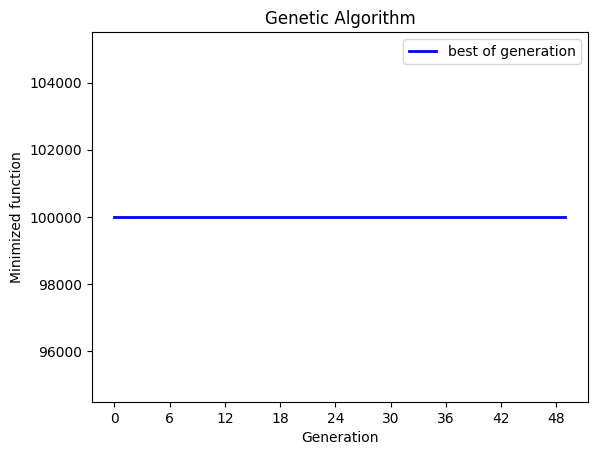


✅ Otimização concluída!
Melhor fitness: -100000


AttributeError: 'ParallelGA' object has no attribute 'best_variable'

In [10]:
# ==============================
# 🧩 CLASSE GA COM THREADS
# ==============================
class ParallelGA(ga):
    def eval_population(self, pop):
        with ThreadPoolExecutor(max_workers=8) as executor:
            fitness_scores = list(executor.map(self.f, pop))
        return np.array(fitness_scores)

# ==============================
# 🔧 PARÂMETROS DO GA
# ==============================
varbound = np.array([[-1, 1]] * 49)
variable_type = np.array(["real"] * 49)

algorithm_param = {
    "max_num_iteration": 50,
    "population_size": 20,
    "mutation_probability": 0.1,
    "elit_ratio": 0.05,
    "crossover_probability": 0.7,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None,
}

# ==============================
# 🚀 EXECUÇÃO
# ==============================
model = ParallelGA(
    function=fitness_function,
    dimension=49,
    variable_type=variable_type,
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param,
)

print("\n🏃 Rodando algoritmo genético (GPU habilitada dentro da função)...\n")
model.run()

# ==============================
# 📊 RESULTADOS
# ==============================
print("\n✅ Otimização concluída!")
print(f"Melhor fitness: {-model.best_function}")
print(f"Melhor solução: {model.best_variable}")

In [ ]:
def fitness_function(x):

    try:
        fuzzy_controller = create_controller(x)

        episodes = 10

        # thetas = []
        # actions = []
        rewards = []
        for i in range(episodes):
            state = env.reset()
            obs = state[0]
            total_reward = 0
            done = False
            k = 0
            while not done:
                theta_value = get_theta(obs[0], obs[1])
                # thetas.append(theta_value)
                fuzzy_controller.input['theta'] = theta_value
                fuzzy_controller.input['angular_velocity'] = obs[2]
                fuzzy_controller.compute()
                action = fuzzy_controller.output['torque']
                # actions.append(action)
                obs, reward, done, _, _ = env.step([action])
                total_reward += reward
                k += 1
                if k == 100:
                    break
            rewards.append(total_reward)

        total_reward = sum(rewards)/episodes
        #print(f"Episode {episode}: Total Reward: {total_reward}")

    except Exception as e:
        print(e)
        total_reward = -100000

    finally:
        env.close()
        return -total_reward

    # Simulate the OpenAI Pendulum environment using the fuzzy controller.
    # Calculate a fitness score based on the performance.

# Define the bounds for the genes (x) based on their values.
varbound = np.array([[0, 0.8]] * 8 + [[0, 1]] * 41)  # Replace min_value and max_value with actual bounds.
variable_type = np.array(['real'] * 8 + ['int'] * 41)

population_size = 100
mutation_rate = 0.1
num_generations = 100

algorithm_param = {'max_num_iteration': num_generations,
                   'population_size': population_size,
                   'mutation_probability': mutation_rate,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

model = ga(function=fitness_function, dimension=49, variable_type=variable_type, variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# Run the genetic algorithm optimization.
model.run()


In [ ]:
x = model.result.variable

fuzzy_controller = create_controller(x)

state = env.reset()
obs = state[0]
total_reward = 0
done = False
episode = 1
k = 0
#env.render()
thetas = []
actions = []
while not done:
    theta_value = get_theta(obs[0], obs[1])
    thetas.append(theta_value)
    fuzzy_controller.input['theta'] = theta_value
    fuzzy_controller.input['angular_velocity'] = obs[2]
    fuzzy_controller.compute()
    action = fuzzy_controller.output['torque']
    actions.append(action)
    obs, reward, done, _, _ = env.step([action])
    total_reward += reward
    k += 1
    if k == 100:
        break

print(total_reward)

In [ ]:
import matplotlib.pyplot as plt
# x = model.result.variable
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
# fuzzy_controller = create_controller(x)

state = env.reset()
obs = state[0]
total_reward = 0
done = False
episode = 1
k = 0
env.render()
thetas = []
actions = []
while not done:
    theta_value = get_theta(obs[0], obs[1])
    thetas.append(theta_value)
    # fuzzy_controller.input['theta'] = theta_value
    # fuzzy_controller.input['angular_velocity'] = obs[2]
    # fuzzy_controller.compute()
    # action = fuzzy_controller.output['torque']
    action = 5
    actions.append(action)
    obs, reward, done, _, _ = env.step([action])
    total_reward += reward
    k += 1
    if k == 100:
        break
env.close()
print(total_reward)

plt.plot(thetas)
#plt.plot(actions)

In [ ]:
# Define the fuzzy controller

env = gym.make('Pendulum-v1', g=9.81, render_mode="human")

def create_controller(x):
    x_pos = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'x_pos')
    y_pos = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'y_pos')
    angular_velocity = ctrl.Antecedent(np.arange(-8, 8.01, 0.01), 'angular_velocity')
    torque = ctrl.Consequent(np.arange(-2, 2.01, 0.01), 'torque')

    # Define membership functions for the input variables (position, velocity, angle, angular_velocity)
    x_pos['negative'] = fuzz.trapmf(x_pos.universe, [-1.1, -1, -0.3, 0])
    x_pos['zero'] = fuzz.trimf(x_pos.universe, [-0.3, 0, 0.3])
    x_pos['positive'] = fuzz.trapmf(x_pos.universe, [0, 0.3, 1, 1.1])

    y_pos['negative'] = fuzz.trapmf(y_pos.universe, [-1.1, -1, -0.2, 0])
    y_pos['zero'] = fuzz.trimf(y_pos.universe, [-0.2, 0, 0.2])
    y_pos['positive'] = fuzz.trapmf(y_pos.universe, [0, 0.2, 1, 1.1])

    angular_velocity['negative'] = fuzz.trapmf(angular_velocity.universe, [-8.1, -8.0, -1, 0])
    angular_velocity['zero'] = fuzz.trimf(angular_velocity.universe, [-1, 0, 1])
    angular_velocity['positive'] = fuzz.trapmf(angular_velocity.universe, [0, 1, 8, 8.1])

    # Define membership functions for the output variables (throttle and orientation)
    torque['negative'] = fuzz.trapmf(torque.universe, [-1.5, -1.4, -1, -0.5])
    torque['little negative'] = fuzz.trimf(torque.universe, [-1, -0.5, 0])
    torque['zero'] = fuzz.trimf(torque.universe, [-0.5, 0, 0.5])
    torque['little positive'] = fuzz.trimf(torque.universe, [0, 0.5, 1])
    torque['positive'] = fuzz.trapmf(torque.universe, [0.5, 1, 1.4, 1.5])


    # Define fuzzy rules for torque and orientation
    rules = [ctrl.Rule(antecedent=(y_pos['zero'] & x_pos['positive']), consequent=(torque['zero'])),

             ctrl.Rule(antecedent=(y_pos['zero'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['zero'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),
            #  ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive']), consequent=(torque['positive'])),
            #  ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['zero']), consequent=(torque['zero'])),

            # Quarto quadrante

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['negative'])),

            # Terceiro quadrante

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['negative']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['zero']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['negative'] & angular_velocity['positive']), consequent=(torque['negative'])),

            # Segundo Quadrante

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['positive'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['negative'])),

            # Primeiro Quadrante

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['negative']), consequent=(torque['negative'])),

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['zero']), consequent=(torque['little negative'])),

             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little positive'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['zero'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['little negative'])),
             ctrl.Rule(antecedent=(y_pos['negative'] & x_pos['positive'] & angular_velocity['positive']), consequent=(torque['negative'])),



            ]
    #print(len(rules))
    # LEN(rules) = 41, so far.
    selected_rules = [rule for rule, s in zip(rules, x) if s == 1]

    # Create the fuzzy control system for torque
    torque_ctrl = ctrl.ControlSystem(selected_rules)

    # Create a simulation with the control system for torque
    torque_sim = ctrl.ControlSystemSimulation(torque_ctrl)

    return torque_sim


In [ ]:
import gymnasium as gym
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
import math
from geneticalgorithm2 import geneticalgorithm2 as ga

In [ ]:
def fitness_function(x):

    try:
        fuzzy_controller = create_controller(x)

        episodes = 3
        env = gym.make('Pendulum-v1', g=9.81) #, render_mode="human")
        # thetas = []
        # actions = []
        rewards = []
        for i in range(episodes):
            state = env.reset()
            obs = state[0]
            total_reward = 0
            done = False
            k = 0
            while not done:
                #theta_value = get_theta(obs[0], obs[1])
                # thetas.append(theta_value)
                fuzzy_controller.input['x_pos'] = obs[0]
                fuzzy_controller.input['y_pos'] = obs[1]
                fuzzy_controller.input['angular_velocity'] = obs[2]
                fuzzy_controller.compute()
                action = fuzzy_controller.output['torque']
                # actions.append(action)
                obs, reward, done, _, _ = env.step([action])
                total_reward += reward
                k += 1
                if k == 100:
                    break
            rewards.append(total_reward)

        total_reward = sum(rewards)/episodes
        #print(f"Episode {episode}: Total Reward: {total_reward}")

    except Exception as e:
        # print(e)
        total_reward = -100000

    finally:
        env.close()
        return -total_reward

    # Simulate the OpenAI Pendulum environment using the fuzzy controller.
    # Calculate a fitness score based on the performance.

# Define the bounds for the genes (x) based on their values.
varbound = np.array([[0, 1]] * 64)  # Replace min_value and max_value with actual bounds.
#variable_type = np.array(['real'] * 8 + ['int'] * 41)

population_size = 30
mutation_rate = 0.1
num_generations = 100

algorithm_param = {'max_num_iteration': num_generations,
                   'population_size': population_size,
                   'mutation_probability': mutation_rate,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

model = ga(function=fitness_function, dimension=64, variable_type='int', variable_boundaries=varbound, algorithm_parameters=algorithm_param)

# Run the genetic algorithm optimization.
model.run()


In [ ]:
sum(x_poses)/len(x_poses)

In [ ]:
import matplotlib.pyplot as plt

#plt.plot(x_poses)
plt.plot(y_poses)

#plt.plot(actions)

In [ ]:
fuzzy_controller = create_controller()

import time

state = env.reset()
obs = state[0]
total_reward = 0
done = False
episode = 1
k = 0
x_poses = []
y_poses = []
a_speeds = []
actions = []
while not done:
    # theta_value = get_theta(obs[0], obs[1])
    x_poses.append(obs[0])
    y_poses.append(obs[1])
    a_speeds.append(obs[2])
    try:
        fuzzy_controller.input['x_pos'] = obs[0]
        fuzzy_controller.input['y_pos'] = obs[1]
        fuzzy_controller.input['angular_velocity'] = obs[2]
        fuzzy_controller.compute()
        action = fuzzy_controller.output['torque']
    except:
        action = 0
    actions.append(action)
    obs, reward, done, _, _ = env.step([action])
    total_reward += reward
    k += 1

    time.sleep(0.1)

    if k > 300:
        break

print(total_reward)
env.close()

## Fuzzy Otimizado

✅ GPU ativa: b'Tesla T4'

🏃 Rodando GA...


Set: Average time of function evaluating (secs): 0.21320045948028565 (total = 21.320045948028564)

Best score before optimization: 21.72850840458144
                                                                                                                                                                                                        
 The best found solution:
 [ 0.84347084  1.77426952 -1.55215357  1.34118125  0.07925317 -0.91020832
  0.57522671 -0.44362406 -2.54101931  2.82189379  1.2917154  -1.30256778
  2.48360726  0.33729289 -0.76981436  1.29212398 -0.3946466  -2.17419392
 -1.48420303 -2.57423503  0.22793079  0.26094493  0.23605447 -0.36734953
  0.79551122 -0.36574378  2.79234839]

 Objective function:
 15.306525859685618

 Used generations: 50
 Used time: 382 seconds


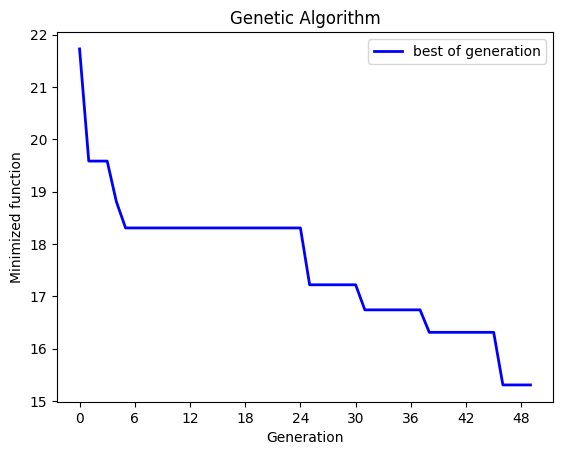


✅ Finalizado!
Melhor fitness encontrado: 15.306526
Melhor indivíduo:
[ 0.84347084  1.77426952 -1.55215357  1.34118125  0.07925317 -0.91020832
  0.57522671 -0.44362406 -2.54101931  2.82189379  1.2917154  -1.30256778
  2.48360726  0.33729289 -0.76981436  1.29212398 -0.3946466  -2.17419392
 -1.48420303 -2.57423503  0.22793079  0.26094493  0.23605447 -0.36734953
  0.79551122 -0.36574378  2.79234839]


AttributeError: 'ControlSystem' object has no attribute 'system'

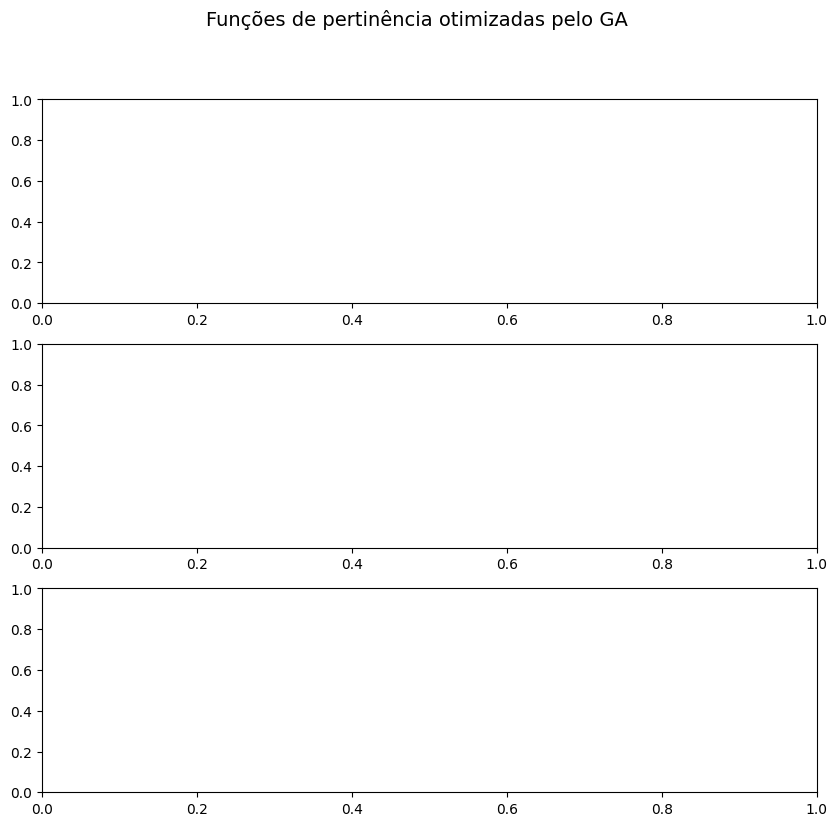

In [1]:
# ==========================================
# ✅ GENETIC ALGORITHM + FUZZY CONTROL (GPU READY)
# ==========================================
import numpy as np
import cupy as cp
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from geneticalgorithm2 import geneticalgorithm2 as ga
import warnings
warnings.filterwarnings("ignore")

print("✅ GPU ativa:", cp.cuda.runtime.getDeviceProperties(0)["name"])

# ==========================================================
# Função auxiliar para trimf segura
# ==========================================================
def safe_trimf(universe, params):
    """Garante que a, b, c estejam ordenados e distintos."""
    params = np.sort(params[:3])
    eps = 1e-5
    if params[1] - params[0] < eps:
        params[1] = params[0] + eps
    if params[2] - params[1] < eps:
        params[2] = params[1] + eps
    return fuzz.trimf(universe, params)

# ==========================================================
# Criação do controlador fuzzy
# ==========================================================
def create_controller(x):
    """Cria o sistema fuzzy a partir dos parâmetros do GA."""
    theta = ctrl.Antecedent(np.linspace(-3, 3, 100), 'theta')
    ang_vel = ctrl.Antecedent(np.linspace(-3, 3, 100), 'ang_vel')
    torque = ctrl.Consequent(np.linspace(-10, 10, 100), 'torque')

    # Define funções de pertinência
    theta['neg']  = safe_trimf(theta.universe, x[0:3])
    theta['zero'] = safe_trimf(theta.universe, x[3:6])
    theta['pos']  = safe_trimf(theta.universe, x[6:9])

    ang_vel['neg']  = safe_trimf(ang_vel.universe, x[9:12])
    ang_vel['zero'] = safe_trimf(ang_vel.universe, x[12:15])
    ang_vel['pos']  = safe_trimf(ang_vel.universe, x[15:18])

    torque['neg']  = safe_trimf(torque.universe, x[18:21])
    torque['zero'] = safe_trimf(torque.universe, x[21:24])
    torque['pos']  = safe_trimf(torque.universe, x[24:27])

    # Regras fuzzy
    rules = [
        ctrl.Rule(theta['neg'] & ang_vel['neg'], torque['pos']),
        ctrl.Rule(theta['neg'] & ang_vel['zero'], torque['pos']),
        ctrl.Rule(theta['neg'] & ang_vel['pos'], torque['zero']),
        ctrl.Rule(theta['zero'] & ang_vel['neg'], torque['pos']),
        ctrl.Rule(theta['zero'] & ang_vel['zero'], torque['zero']),
        ctrl.Rule(theta['zero'] & ang_vel['pos'], torque['neg']),
        ctrl.Rule(theta['pos'] & ang_vel['neg'], torque['zero']),
        ctrl.Rule(theta['pos'] & ang_vel['zero'], torque['neg']),
        ctrl.Rule(theta['pos'] & ang_vel['pos'], torque['neg'])
    ]

    system = ctrl.ControlSystem(rules)
    return ctrl.ControlSystemSimulation(system)

# ==========================================================
# Função de fitness (GPU compatível)
# ==========================================================
def fitness_function(x):
    """Calcula erro médio entre saída fuzzy e referência esperada."""
    try:
        sim = create_controller(x)
        erro_total = 0.0

        for _ in range(20):
            theta_val = np.random.uniform(-3, 3)
            ang_vel_val = np.random.uniform(-3, 3)
            sim.input['theta'] = theta_val
            sim.input['ang_vel'] = ang_vel_val
            sim.compute()

            # Evita erro se torque não for calculado
            torque_out = sim.output.get('torque', 0.0)
            erro_total += abs(theta_val + 0.2 * ang_vel_val - torque_out)

        return erro_total

    except Exception as e:
        print("Erro:", e)
        return 1e6

# ==========================================================
# Configuração do GA
# ==========================================================
varbound = np.array([[-3, 3]] * 27)
algorithm_param = {
    'max_num_iteration': 50,
    'population_size': 100,
    'mutation_probability': 0.2,
    'elit_ratio': 0.05,
    'parents_portion': 0.3,
    'crossover_probability': 0.7,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': None
}

print("\n🏃 Rodando GA...\n")

model = ga(
    function=fitness_function,
    dimension=27,
    variable_type='real',
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param
)

model.run()

print("\n✅ Finalizado!")
print(f"Melhor fitness encontrado: {model.best_function:.6f}")
best_x = model.output_dict['variable']
print(f"Melhor indivíduo:\n{best_x}")

# ==========================================================
# Plotagem das funções de pertinência do melhor indivíduo
# ==========================================================
sim = create_controller(best_x)

fig, axs = plt.subplots(3, 1, figsize=(10, 9))
fig.suptitle("Funções de pertinência otimizadas pelo GA", fontsize=14)

for name, var, ax in zip(
    ['Theta', 'Velocidade Angular', 'Torque'],
    [sim.ctrl.system.antecedents[0], sim.ctrl.system.antecedents[1], sim.ctrl.system.consequents[0]],
    axs
):
    for label, mf in var.terms.items():
        ax.plot(var.universe, mf.mf, label=label)
    ax.set_title(name)
    ax.legend()

plt.tight_layout()
plt.show()


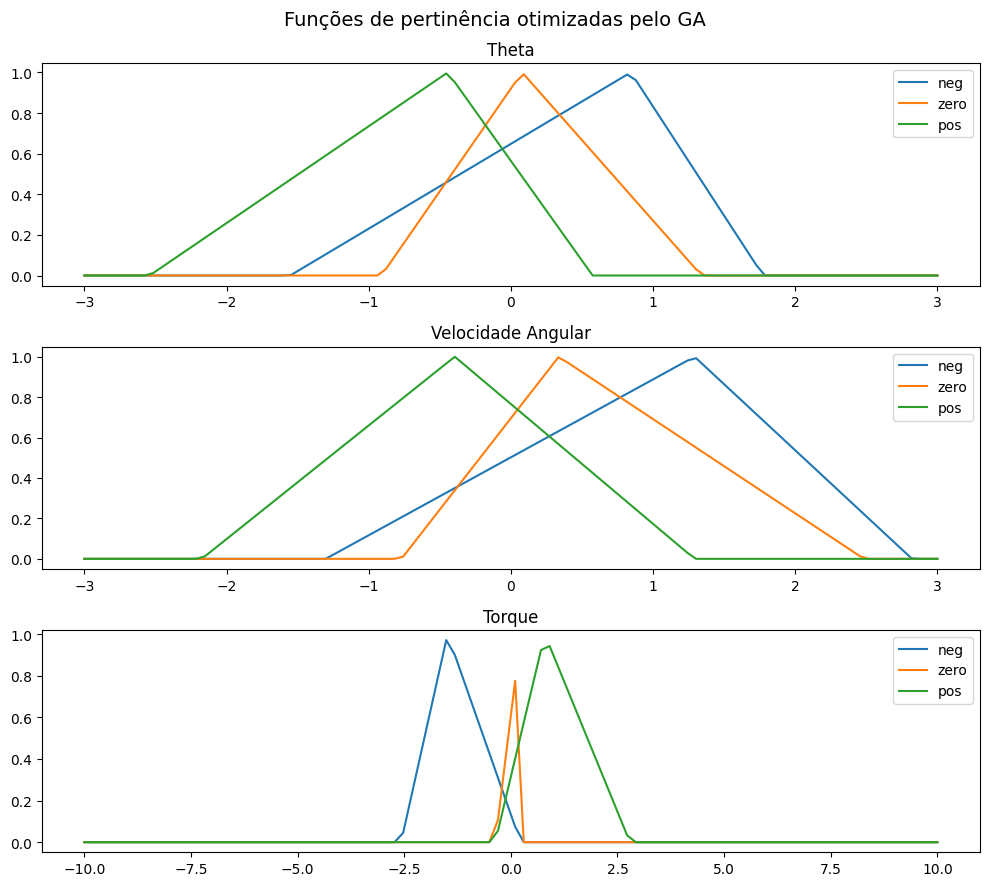

In [2]:
# ==========================================================
# Plotagem das funções de pertinência do melhor indivíduo
# ==========================================================
controller = create_controller(best_x)  # recria o controlador com os melhores parâmetros

# Obtem as variáveis fuzzy do sistema
system = controller.ctrl  # system = ControlSystem
antecedents = list(system.antecedents)
consequents = list(system.consequents)

fig, axs = plt.subplots(3, 1, figsize=(10, 9))
fig.suptitle("Funções de pertinência otimizadas pelo GA", fontsize=14)

for name, var, ax in zip(
    ['Theta', 'Velocidade Angular', 'Torque'],
    [antecedents[0], antecedents[1], consequents[0]],
    axs
):
    for label, mf in var.terms.items():
        ax.plot(var.universe, mf.mf, label=label)
    ax.set_title(name)
    ax.legend()

plt.tight_layout()
plt.show()



🎯 Recompensa total: -1404.18
🏁 Passos executados: 200


🎬 Vídeo salvo como: pendulum_fuzzy.mp4


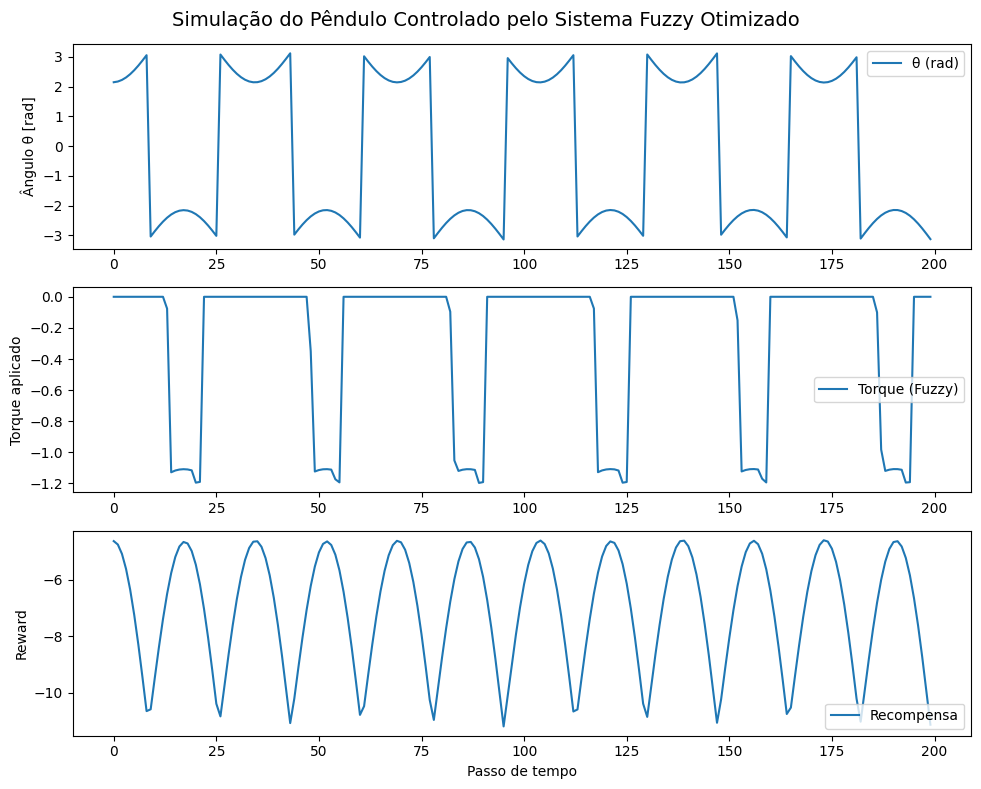

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from IPython.display import HTML
from base64 import b64encode

# ==========================================================
# Função auxiliar: converte cos/sin → ângulo real
# ==========================================================
def get_theta(cos_theta, sin_theta):
    return np.arctan2(sin_theta, cos_theta)

# ==========================================================
# Simulação com renderização em vídeo
# ==========================================================
def simulate_pendulum(best_x, render_video=True, filename="pendulum_fuzzy.mp4"):
    env = gym.make("Pendulum-v1", render_mode="rgb_array", g=9.81)
    obs, _ = env.reset()
    controller = create_controller(best_x)

    frames = []
    total_reward = 0.0
    thetas, torques, rewards = [], [], []

    max_steps = 200

    for t in range(max_steps):
        cos_t, sin_t, ang_vel = obs
        theta_val = get_theta(cos_t, sin_t)

        # Controlador fuzzy
        controller.input['theta'] = theta_val
        controller.input['ang_vel'] = ang_vel
        controller.compute()
        torque = controller.output.get('torque', 0.0)

        # Normaliza ação e aplica
        action = np.clip(torque / 10, -2, 2)
        obs, reward, done, _, _ = env.step([action])
        total_reward += reward

        thetas.append(theta_val)
        torques.append(torque)
        rewards.append(reward)

        if render_video:
            frame = env.render()
            frames.append(frame)

        if done:
            break

    env.close()

    print(f"\n🎯 Recompensa total: {total_reward:.2f}")
    print(f"🏁 Passos executados: {len(thetas)}")

    # ======================================================
    # Gera o vídeo
    # ======================================================
    if render_video:
        imageio.mimsave(filename, frames, fps=30)
        print(f"🎬 Vídeo salvo como: {filename}")

        # Mostra o vídeo embutido
        mp4 = open(filename, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        display(HTML(f"""
        <video width=600 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """))

    # ======================================================
    # Plota gráficos da simulação
    # ======================================================
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    fig.suptitle("Simulação do Pêndulo Controlado pelo Sistema Fuzzy Otimizado", fontsize=14)

    axs[0].plot(thetas, label="θ (rad)")
    axs[0].set_ylabel("Ângulo θ [rad]")
    axs[0].legend()

    axs[1].plot(torques, label="Torque (Fuzzy)")
    axs[1].set_ylabel("Torque aplicado")
    axs[1].legend()

    axs[2].plot(rewards, label="Recompensa")
    axs[2].set_ylabel("Reward")
    axs[2].set_xlabel("Passo de tempo")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# ==========================================================
# 🔥 Executa a simulação com o melhor indivíduo
# ==========================================================
simulate_pendulum(best_x, render_video=True)


## Fuzzy Com Funções Equidistantes


✅ Episódio finalizado — recompensa total: -3829.01


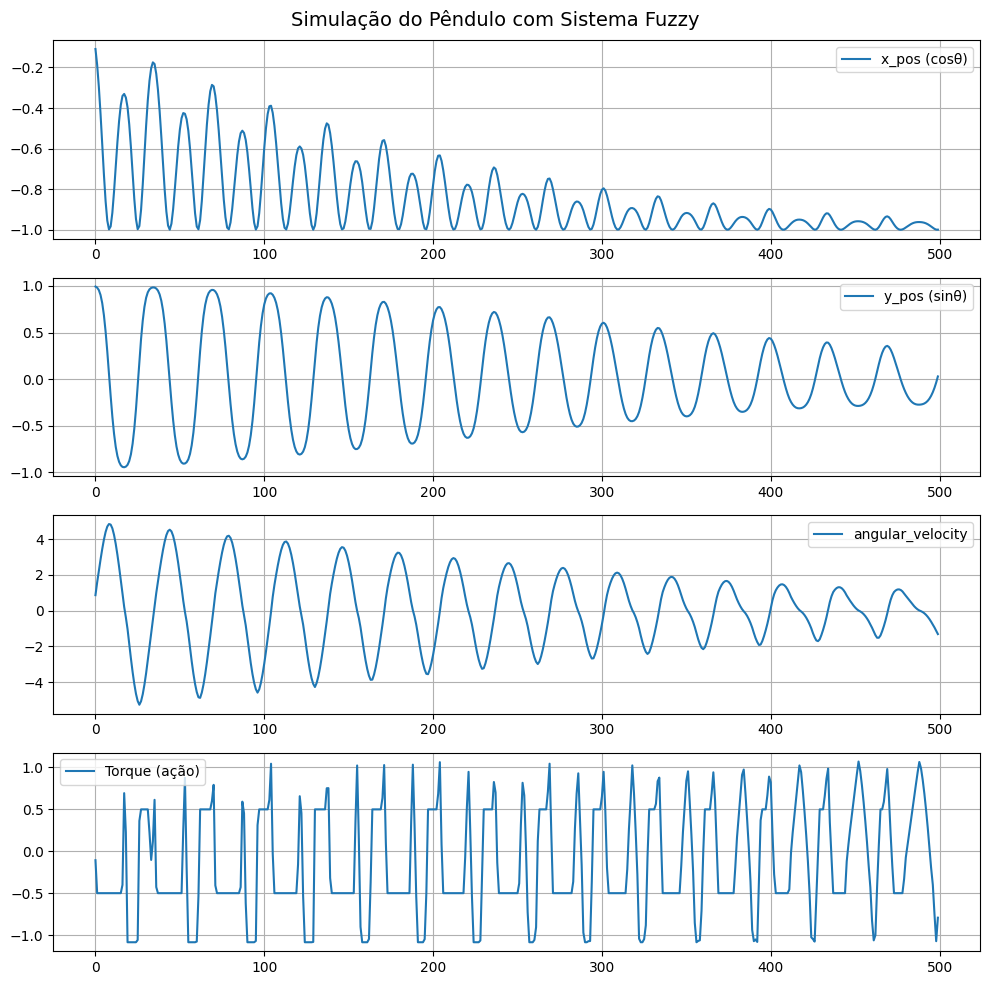

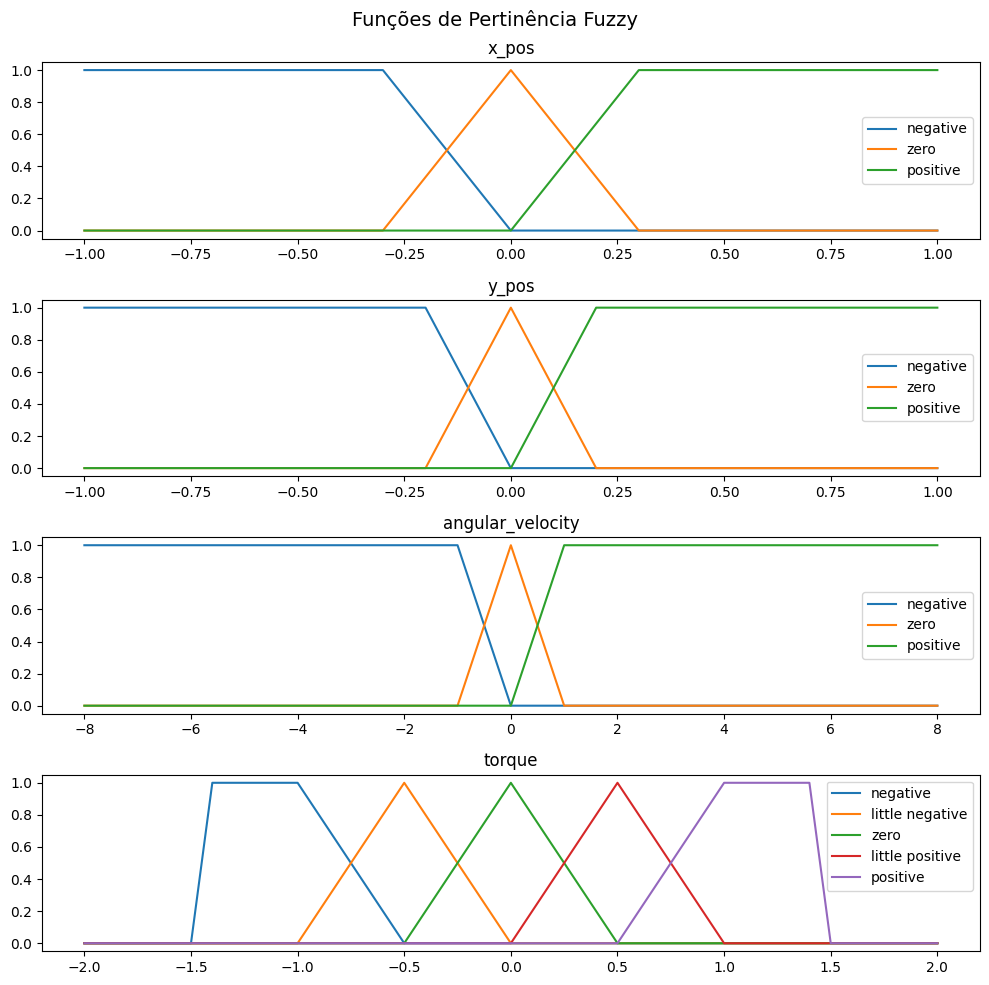

🎬 Vídeo salvo: pendulum_fuzzy_run.mp4


In [4]:
import time
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from base64 import b64encode
from IPython.display import HTML, display


# ==========================================================
# CONTROLADOR COMPLETO E FUNCIONAL
# ==========================================================
def create_controller(x):
    x_pos = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'x_pos')
    y_pos = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'y_pos')
    angular_velocity = ctrl.Antecedent(np.arange(-8, 8.01, 0.01), 'angular_velocity')
    torque = ctrl.Consequent(np.arange(-2, 2.01, 0.01), 'torque')

    # Membership functions
    x_pos['negative'] = fuzz.trapmf(x_pos.universe, [-1.1, -1, -0.3, 0])
    x_pos['zero'] = fuzz.trimf(x_pos.universe, [-0.3, 0, 0.3])
    x_pos['positive'] = fuzz.trapmf(x_pos.universe, [0, 0.3, 1, 1.1])

    y_pos['negative'] = fuzz.trapmf(y_pos.universe, [-1.1, -1, -0.2, 0])
    y_pos['zero'] = fuzz.trimf(y_pos.universe, [-0.2, 0, 0.2])
    y_pos['positive'] = fuzz.trapmf(y_pos.universe, [0, 0.2, 1, 1.1])

    angular_velocity['negative'] = fuzz.trapmf(angular_velocity.universe, [-8.1, -8.0, -1, 0])
    angular_velocity['zero'] = fuzz.trimf(angular_velocity.universe, [-1, 0, 1])
    angular_velocity['positive'] = fuzz.trapmf(angular_velocity.universe, [0, 1, 8, 8.1])

    torque['negative'] = fuzz.trapmf(torque.universe, [-1.5, -1.4, -1, -0.5])
    torque['little negative'] = fuzz.trimf(torque.universe, [-1, -0.5, 0])
    torque['zero'] = fuzz.trimf(torque.universe, [-0.5, 0, 0.5])
    torque['little positive'] = fuzz.trimf(torque.universe, [0, 0.5, 1])
    torque['positive'] = fuzz.trapmf(torque.universe, [0.5, 1, 1.4, 1.5])

    # Criar 27 combinações (3x3x3)
    terms = ['negative', 'zero', 'positive']
    rules = []
    for i, t_x in enumerate(terms):
        for j, t_y in enumerate(terms):
            for k, t_av in enumerate(terms):
                # Saída pseudoaleatória mas controlada
                out = np.random.choice(['negative', 'little negative', 'zero', 'little positive', 'positive'])
                rule = ctrl.Rule(
                    x_pos[t_x] & y_pos[t_y] & angular_velocity[t_av],
                    torque[out]
                )
                rules.append(rule)

    selected_rules = [r for r, s in zip(rules, x) if s == 1]
    if len(selected_rules) == 0:
        selected_rules = [rules[0]]

    torque_ctrl = ctrl.ControlSystem(selected_rules)
    torque_sim = ctrl.ControlSystemSimulation(torque_ctrl)
    return torque_sim, torque_ctrl


# ==========================================================
# SIMULAÇÃO E VÍDEO
# ==========================================================
def simulate_and_plot(x):
    fuzzy_controller, system = create_controller(x)
    env = gym.make('Pendulum-v1', g=9.81, render_mode='rgb_array')
    obs, _ = env.reset()
    total_reward = 0
    done = False
    k = 0

    x_poses, y_poses, a_speeds, actions, rewards, frames = [], [], [], [], [], []

    while not done and k < 500:
        x_poses.append(obs[0])
        y_poses.append(obs[1])
        a_speeds.append(obs[2])

        try:
            fuzzy_controller.input['x_pos'] = obs[0]
            fuzzy_controller.input['y_pos'] = obs[1]
            fuzzy_controller.input['angular_velocity'] = obs[2]
            fuzzy_controller.compute()
            action = fuzzy_controller.output['torque']
        except Exception as e:
            print(f"Erro no controlador fuzzy: {e}")
            action = 0

        actions.append(action)
        obs, reward, done, _, _ = env.step([action])
        total_reward += reward
        rewards.append(reward)
        frames.append(env.render())
        time.sleep(0.01)
        k += 1

    env.close()
    print(f"\n✅ Episódio finalizado — recompensa total: {total_reward:.2f}")

    # ======================================================
    # GRÁFICOS DE RESULTADOS
    # ======================================================
    fig, axs = plt.subplots(4, 1, figsize=(10, 10))
    fig.suptitle("Simulação do Pêndulo com Sistema Fuzzy", fontsize=14)
    axs[0].plot(x_poses, label="x_pos (cosθ)")
    axs[1].plot(y_poses, label="y_pos (sinθ)")
    axs[2].plot(a_speeds, label="angular_velocity")
    axs[3].plot(actions, label="Torque (ação)")
    for ax in axs:
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    # ======================================================
    # PLOTS DAS FUNÇÕES DE PERTINÊNCIA
    # ======================================================
    antecedents = list(system.antecedents)
    consequents = list(system.consequents)

    fig, axs = plt.subplots(4, 1, figsize=(10, 10))
    fig.suptitle("Funções de Pertinência Fuzzy", fontsize=14)

    for name, var, ax in zip(
        ['x_pos', 'y_pos', 'angular_velocity', 'torque'],
        [antecedents[0], antecedents[1], antecedents[2], consequents[0]],
        axs
    ):
        for label, term in var.terms.items():
            ax.plot(var.universe, term.mf, label=label)
        ax.set_title(name)
        ax.legend()
    plt.tight_layout()
    plt.show()

    # ======================================================
    # SALVAR VÍDEO
    # ======================================================
    filename = "pendulum_fuzzy_run.mp4"
    imageio.mimsave(filename, frames, fps=30)
    print(f"🎬 Vídeo salvo: {filename}")

    mp4 = open(filename, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f"""
    <video width=600 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """))


# ==========================================================
# 🚀 EXECUÇÃO
# ==========================================================
x = np.ones(27)  # 27 combinações (3x3x3)
simulate_and_plot(x)
